In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, lfilter
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, LSTM,Dropout,Conv2D,TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, SpatialDropout2D, Permute
from tensorflow.keras.callbacks import ModelCheckpoint

d:\pYthon_Directory\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\pYthon_Directory\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization,
    Activation, AveragePooling2D, Dropout, Flatten, Dense, Multiply,
    Conv1D, GlobalAveragePooling1D, Reshape
)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf


class EEGNetWithAttentionConv1D(Model):
    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.3,
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
        super(EEGNetWithAttentionConv1D, self).__init__()

        # Temporal Conv Layer
        self.conv1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()

        # Depthwise Spatial Conv Layer
        self.depthwise = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                                         depthwise_constraint=max_norm(1.))
        self.bn2 = BatchNormalization()
        self.act1 = Activation('elu')
        self.pool1 = AveragePooling2D((1, 4))
        self.drop1 = Dropout(dropoutRate)

        # Separable Conv Layer
        self.sepconv = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')
        self.bn3 = BatchNormalization()
        self.act2 = Activation('elu')
        self.pool2 = AveragePooling2D((1, 8))
        self.drop2 = Dropout(dropoutRate)

        # Attention (with regularization)
        self.attention_conv = Conv2D(1, (1, 1), activation='sigmoid', padding='same',
                                     kernel_regularizer=l2(1e-4))

        # Temporal Conv Block
        self.reshape_for_conv1d = Reshape((-1, F2))  # (batch, time_steps, features)
        self.conv1d = Conv1D(64, kernel_size=3, padding='same', activation='relu')
        self.bn4 = BatchNormalization()
        self.global_pool = GlobalAveragePooling1D()

        # Final classifier
        self.classifier = Dense(nb_classes, activation='softmax',
                                kernel_constraint=max_norm(norm_rate), name='softmax')

    def spatial_attention_module(self, x):
        attention = tf.reduce_mean(x, axis=-1, keepdims=True)  # Mean over filters
        attention = self.attention_conv(attention)              # Apply conv to attention map
        return Multiply()([x, attention])                       # Apply attention

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)

        x = self.depthwise(x)
        x = self.bn2(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.sepconv(x)
        x = self.bn3(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        # Apply spatial attention
        x = self.spatial_attention_module(x)

        # Temporal Conv1D block
        x = self.reshape_for_conv1d(x)
        x = self.conv1d(x)
        x = self.bn4(x, training=training)
        x = self.global_pool(x)

        # Classifier
        return self.classifier(x)



In [3]:
model = EEGNetWithAttentionConv1D(nb_classes=2, Chans=14, Samples=128)
model.build(input_shape=(None, 14, 128, 1))
model.summary()

Model: "eeg_net_with_attention_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  512       
                                                                 
 batch_normalization (BatchN  multiple                 32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  multiple                 224       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                     

In [5]:
# load EEG Data
eeg=np.load('D:/lab_work_25/july/NEW WORK/mental_Data/processed_data/segments_shuffled.npy')
label=np.load('D:/lab_work_25/july/NEW WORK/mental_Data/processed_data/segment_labels_shuffled.npy')
print(eeg.shape,label.shape)
label_cat = to_categorical(label, num_classes=2)
print(label_cat.shape)  # Should be (12201, 3) after one-hot encoding

(13455, 128, 14) (13455,)
(13455, 2)


In [6]:
eeg=np.swapaxes(eeg, 1, 2)  # Change shape from (12201, 128, 64) to (12201, 64, 128)
print(eeg.shape,label_cat.shape)
eeg=np.expand_dims(eeg, axis=-1)  # Add a channel dimension, shape becomes (12201, 64, 128, 1)
print(eeg.shape,label_cat.shape)

(13455, 14, 128) (13455, 2)
(13455, 14, 128, 1) (13455, 2)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(eeg, label_cat, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)  # Should be (6000, 1024, 1) and (6000, 3)
print(X_test.shape, y_test.shape)  # Should be (6000, 1024, 1) and (6000, 3)

(10764, 14, 128, 1) (10764, 2)
(2691, 14, 128, 1) (2691, 2)


In [8]:
nb_classes = 2
Chans = 14
Samples = 128
num_samples = 10764

In [9]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "eeg_net_with_attention_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  512       
                                                                 
 batch_normalization (BatchN  multiple                 32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  multiple                 224       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                     

In [10]:
# Instantiate model
model = EEGNetWithAttentionConv1D(nb_classes=2, Chans=14, Samples=128)

# Compile with lower learning rate and gradient clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping (optional)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('D:/lab_work_25/july/NEW WORK/mental_Data/model_weight/EEGNET_TCN2/best_model_weights.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max',
                             verbose=1)
# Fit the model
history=model.fit(X_train, y_train,
          epochs=600,
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpoint])

Epoch 1/600
268/270 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5490
Epoch 1: val_accuracy improved from -inf to 0.54714, saving model to D:/lab_work_25/july/NEW WORK/mental_Data/model_weight/EEGNET_TCN2\best_model_weights.h5
270/270 [==============================] - 10s 27ms/step - loss: 0.6937 - accuracy: 0.5486 - val_loss: 0.6893 - val_accuracy: 0.5471
Epoch 2/600
270/270 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5708
Epoch 2: val_accuracy improved from 0.54714 to 0.57083, saving model to D:/lab_work_25/july/NEW WORK/mental_Data/model_weight/EEGNET_TCN2\best_model_weights.h5
270/270 [==============================] - 7s 26ms/step - loss: 0.6829 - accuracy: 0.5708 - val_loss: 0.6810 - val_accuracy: 0.5708
Epoch 3/600
268/270 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.5894
Epoch 3: val_accuracy improved from 0.57083 to 0.57455, saving model to D:/lab_work_25/july/NEW WORK/mental_Data/model_weight/E

In [ ]:
model.load_weights('D:/lab_work_25/july/NEW WORK/mental_Data/model_weight/EEGNET_TCN2/best_model_weights.h5')


In [14]:
# Evaluate on training set
loss, acc = model.evaluate(eeg, label_cat)
print(f"Train accuracy: {acc*100:.2f}%")

# Predict on new data
y_pred = model.predict(eeg[:5])
print("Predictions:", np.argmax(y_pred, axis=1))

421/421 [==============================] - 4s 8ms/step - loss: 0.2219 - accuracy: 0.9128
Train accuracy: 91.28%
1/1 [==============================] - 1s 529ms/step
Predictions: [1 1 0 1 1]


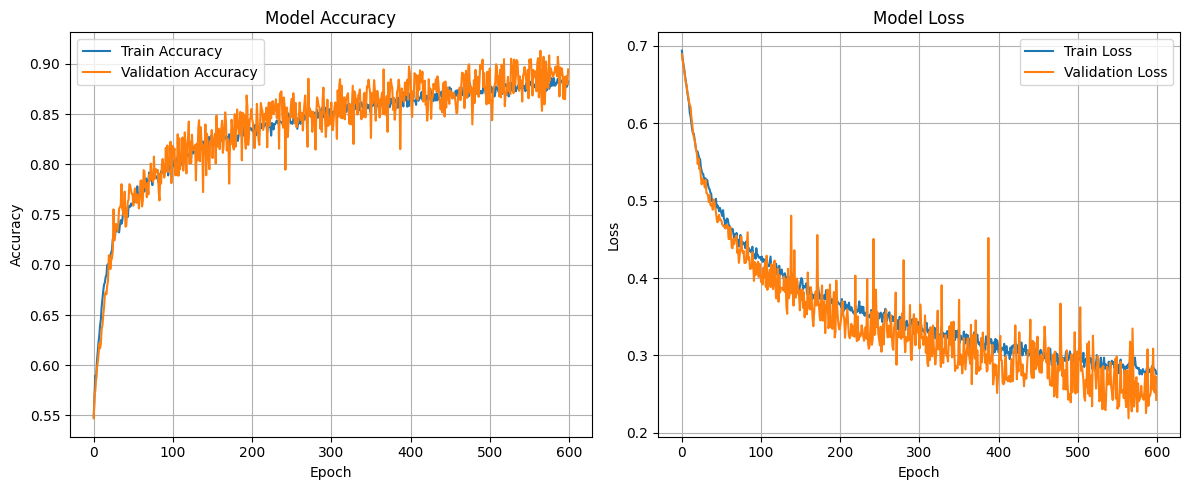

In [15]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

85/85 [==============================] - 1s 8ms/step - loss: 0.2384 - accuracy: 0.9071
Test accuracy: 0.9071
Test loss: 0.2384


In [6]:
class EEGNetWithAttentionConv1D(Model):
    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.3,
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
        super(EEGNetWithAttentionConv1D, self).__init__()

        # Temporal Conv Layer
        self.conv1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()

        # Depthwise Spatial Conv Layer
        self.depthwise = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                                         depthwise_constraint=max_norm(1.))
        self.bn2 = BatchNormalization()
        self.act1 = Activation('elu')
        self.pool1 = AveragePooling2D((1, 4))
        self.drop1 = Dropout(dropoutRate)

        # Separable Conv Layer
        self.sepconv = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')
        self.bn3 = BatchNormalization()
        self.act2 = Activation('elu')
        self.pool2 = AveragePooling2D((1, 8))
        self.drop2 = Dropout(dropoutRate)

        # Attention
        self.attention_conv = Conv2D(1, (1, 1), activation='sigmoid', padding='same',
                                     kernel_regularizer=l2(1e-4))

        # Temporal Conv Block
        self.reshape_for_conv1d = Reshape((-1, F2))
        self.conv1d = Conv1D(64, kernel_size=3, padding='same', activation='relu')
        self.bn4 = BatchNormalization()
        self.global_pool = GlobalAveragePooling1D()

        # Classifier
        self.classifier = Dense(nb_classes, activation='softmax',
                                kernel_constraint=max_norm(norm_rate), name='softmax')

    def spatial_attention_module(self, x):
        attention = tf.reduce_mean(x, axis=-1, keepdims=True)
        attention = self.attention_conv(attention)
        return Multiply()([x, attention])

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)

        x = self.depthwise(x)
        x = self.bn2(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.sepconv(x)
        x = self.bn3(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        x = self.spatial_attention_module(x)

        x = self.reshape_for_conv1d(x)
        x = self.conv1d(x)
        x = self.bn4(x, training=training)
        x = self.global_pool(x)

        return self.classifier(x)

    def print_layer_outputs(self, inputs):
        """Run a forward pass and print each layer's output shape."""
        x = inputs
        print("\n=== Layer Outputs ===")

        x = self.conv1(x)
        print("conv1:", x.shape)

        x = self.bn1(x, training=False)
        print("bn1:", x.shape)

        x = self.depthwise(x)
        print("depthwise:", x.shape)

        x = self.bn2(x, training=False)
        print("bn2:", x.shape)

        x = self.act1(x)
        print("act1:", x.shape)

        x = self.pool1(x)
        print("pool1:", x.shape)

        x = self.drop1(x, training=False)
        print("drop1:", x.shape)

        x = self.sepconv(x)
        print("sepconv:", x.shape)

        x = self.bn3(x, training=False)
        print("bn3:", x.shape)

        x = self.act2(x)
        print("act2:", x.shape)

        x = self.pool2(x)
        print("pool2:", x.shape)

        x = self.drop2(x, training=False)
        print("drop2:", x.shape)

        x = self.spatial_attention_module(x)
        print("attention:", x.shape)

        x = self.reshape_for_conv1d(x)
        print("reshape:", x.shape)

        x = self.conv1d(x)
        print("conv1d:", x.shape)

        x = self.bn4(x, training=False)
        print("bn4:", x.shape)

        x = self.global_pool(x)
        print("global_pool:", x.shape)

        out = self.classifier(x)
        print("classifier:", out.shape)

        return out


In [10]:
# Instantiate model
model = EEGNetWithAttentionConv1D(nb_classes=2, Chans=14, Samples=128)

# Dummy input: (batch=1, Chans=64, Samples=128, 1 channel dimension)
x_dummy = tf.random.normal((10, 14, 128, 1))

# Print each layer's output
model.print_layer_outputs(x_dummy)



=== Layer Outputs ===
conv1: (10, 14, 128, 8)
bn1: (10, 14, 128, 8)
depthwise: (10, 1, 128, 16)
bn2: (10, 1, 128, 16)
act1: (10, 1, 128, 16)
pool1: (10, 1, 32, 16)
drop1: (10, 1, 32, 16)
sepconv: (10, 1, 32, 16)
bn3: (10, 1, 32, 16)
act2: (10, 1, 32, 16)
pool2: (10, 1, 4, 16)
drop2: (10, 1, 4, 16)
attention: (10, 1, 4, 16)
reshape: (10, 4, 16)
conv1d: (10, 4, 64)
bn4: (10, 4, 64)
global_pool: (10, 64)
classifier: (10, 2)


<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.5001525 , 0.4998475 ],
       [0.5006695 , 0.49933055],
       [0.49909952, 0.5009005 ],
       [0.49895898, 0.50104105],
       [0.50015426, 0.4998457 ],
       [0.5002491 , 0.4997509 ],
       [0.5002021 , 0.49979785],
       [0.5004155 , 0.49958456],
       [0.49973154, 0.5002684 ],
       [0.49986574, 0.50013435]], dtype=float32)>